In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#store values in pickles 
from sklearn.externals import joblib

In [4]:
#performence metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
#modules for building ML model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

## Objective

1. Train, CV, Test split.

2. find right max depth of tree using gridsearchcv().

3. Build Decision tree with featurisation techniques AVGW2V, TFIDFW2V 

4. get accuracy, precision scores, confusion matrrix, recall score, f1 score.

## Constraints

1. Decision Tree doesn't work well on BOW, TFIDF, also it takes too much time because of dimensionality problem

2. these are solved in AVGW2V, TFIDFW2V where dimensionallity is small.

3. only 100k points are used.

In [6]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [7]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [8]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [9]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


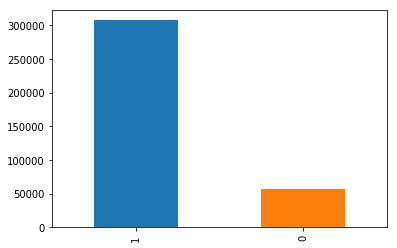

In [10]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [11]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [12]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [13]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [14]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    85197
0    14803
Name: Score, dtype: int64


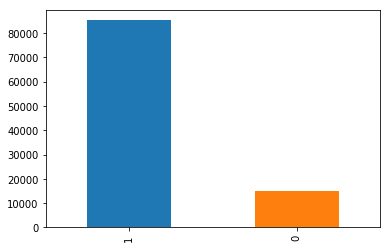

In [15]:
df_sample = df.head(100000)
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [16]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(100000,)
(100000,)


In [17]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (70000,)
y_train shape : (70000,)
X_test shape : (30000,)
y_test shape : (30000,)


In [18]:
joblib.dump(X_train, 'X_train.pkl') 
joblib.dump(X_test, 'X_test.pkl') 
joblib.dump(X_train, 'y_train.pkl') 
joblib.dump(X_test, 'y_test.pkl') 

['y_test.pkl']

In [102]:
X_train = joblib.load('X_train.pkl') 
X_test = joblib.load('X_test.pkl') 
y_train = joblib.load('y_train.pkl') 
y_test = joblib.load('y_test.pkl') 

### check if rows are not shuffled since its time series data

In [18]:
X_train.head()

0    witti littl book make son laugh loud recit car...
1    grew read sendak book watch realli rosi movi i...
2    fun way children learn month year learn poem t...
3    great littl book read nice rhythm well good re...
4    book poetri month year goe month cute littl po...
Name: CleanedText, dtype: object

In [19]:
X_test.head()

70000    introduc madhava agav sister back jan diabet r...
70001    love nectar wish amazon would quit rais price ...
70002    purchas particular item twice price local heal...
70003    madhava agav nectar low calori natur kosher sw...
70004    bought replac honey tendenc crystal winter mon...
Name: CleanedText, dtype: object

In [20]:
X_train.tail()

69995    madhava agav nectar amber bottl pack use agav ...
69996    forget aspartam artifici sweetner agav nectar ...
69997    ferment agav nectar realli refresh drink twist...
69998    love stuff liquid dissolv easier low gci proba...
69999    start eat healthier one ago biggest step chang...
Name: CleanedText, dtype: object

In [21]:
X_test.tail()

99995    delici sugar pretti light brown color delici a...
99996    sugar raw flavor profil much better white suga...
99997    use buy sugar year eat much sugar still sugar ...
99998    product exact advertis save least half retail ...
99999    love sugar also get muscavado sugar great use ...
Name: CleanedText, dtype: object

# Functions to find Hyperparameter & Use Logistic Regression

In [22]:
def DT_best_params (X_train, y_train) :
    #c=1/lambda, lambda = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000. 
    #gamma = 1/sigma, sigma = 0.001,0.002,0.01,0.02,0.1,0.2,1,2,10,20,100,200,1000,2000,10000.
    clf = DecisionTreeClassifier()
    param_grid = {'max_depth' : list(range(1,50))}
    cv = TimeSeriesSplit(n_splits=10)
    grid_cv = GridSearchCV(clf, param_grid, cv=cv, verbose=1, n_jobs=-1)
    grid_cv.fit(X_train, y_train)
    print('best Accuracy:', grid_cv.best_params_)
    print('best Score:', grid_cv.best_score_)
    #plot depth vs CV error
    plt.figure(figsize=(10,6))
    plt.plot(param_grid['max_depth'], grid_cv.cv_results_['mean_test_score'], color='g')
    plt.xlabel('MAX-DEPTH')
    plt.ylabel('Accuracy')

In [23]:
def DT(max_depth, X_train, y_train, X_test, y_test) :
    clf = DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    print('F1_score =', f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    return y_pred

# WORD2VECTOR Model

**AVGW2V & TFIDFW2V takes lot of time to train so we use only first 25k data**

In [24]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [25]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [26]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [29]:
joblib.dump(w2v_model, 'w2v.pkl')

['w2v.pkl']

In [30]:
w2v_model = joblib.load('w2v.pkl')

In [27]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10848
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand']


# AVGW2V

### AVGW2V on train data

In [28]:

# average Word2Vec
# compute average word2vec for each review.
%time train_vectors = []; # the avg-w2v for each sentence/review is stored in this li
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

Wall time: 0 ns
70000
50


In [29]:
avgw2v_train = preprocessing.normalize(train_vectors)

### AVGW2V on test data

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_in_test=[]
for sent in X_test.values:
    list_of_sent_in_test.append(sent.split())

In [31]:
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_in_test[0])

introduc madhava agav sister back jan diabet run famili decid use tea coffe cereal cold hot pass friend famili found also enjoy benefit tast doesnt take much make thing sweet high recommend anyon children well amazon best price
*****************************************************************
['introduc', 'madhava', 'agav', 'sister', 'back', 'jan', 'diabet', 'run', 'famili', 'decid', 'use', 'tea', 'coffe', 'cereal', 'cold', 'hot', 'pass', 'friend', 'famili', 'found', 'also', 'enjoy', 'benefit', 'tast', 'doesnt', 'take', 'much', 'make', 'thing', 'sweet', 'high', 'recommend', 'anyon', 'children', 'well', 'amazon', 'best', 'price']


In [32]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_in_test : # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

30000
50


In [33]:
avgw2v_test = preprocessing.normalize(test_vectors)

In [36]:
joblib.dump(avgw2v_train, 'avgw2v_train.pkl') 
joblib.dump(avgw2v_test, 'avgw2v_test.pkl') 

['avgw2v_test.pkl']

In [37]:
avgw2v_train = joblib.load('avgw2v_train.pkl') 
avgw2v_test = joblib.load('avgw2v_test.pkl') 

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  5.1min finished


best Accuracy: {'max_depth': 6}
best Score: 0.86000314317146


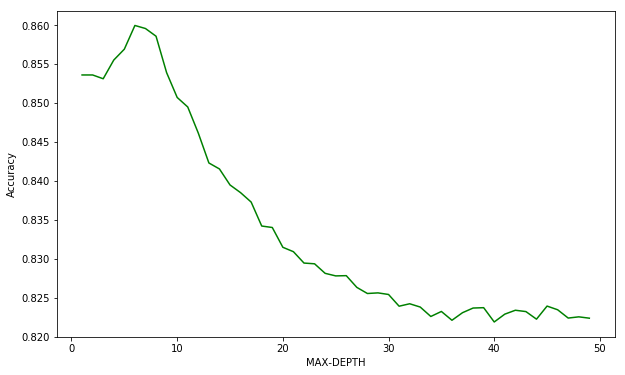

In [34]:
DT_best_params(avgw2v_train, y_train)

In [78]:
from sklearn import tree
tree.export_graphviz(clf,out_file='tree.dot')

accuracy_score = 0.8648
precision_score = 0.8820290575823239
recall_score = 0.971249755525132
F1_score = 0.9244917715392061


array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

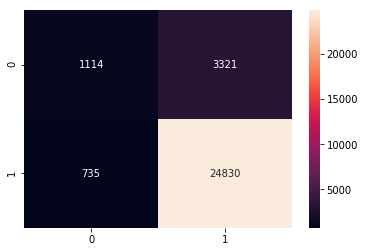

In [35]:
DT(6, avgw2v_train, y_train, avgw2v_test, y_test)

# TFIDFW2V

### TFIDFW2V on Train data

In [38]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf_train = tf_idf_vect.fit_transform(X_train.values)
final_tf_idf_test = tf_idf_vect.transform(X_test.values)

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(len(tfidf_train_vectors))
print(len(tfidf_train_vectors[0]))

70000
50


In [40]:
tfidfw2v_train = preprocessing.normalize(tfidf_train_vectors)
#tfidfw2v_train = tfidf_train_vectors

### TFIDFW2V on Test Data

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_in_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(len(tfidf_test_vectors))
print(len(tfidf_test_vectors[0]))


30000
50


In [42]:
tfidfw2v_test = preprocessing.normalize(tfidf_test_vectors)
tfidfw2v_test.shape

(30000, 50)

In [45]:
joblib.dump(tfidfw2v_train, 'tfidfw2v_train.pkl') 
joblib.dump(tfidfw2v_test, 'tfidfw2v_test.pkl') 

['tfidfw2v_test.pkl']

In [46]:
tfidfw2v_train = joblib.load('tfidfw2v_train.pkl') 
tfidfw2v_test = joblib.load('tfidfw2v_test.pkl') 

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  4.9min finished


best Accuracy: {'max_depth': 4}
best Score: 0.8551783749803552


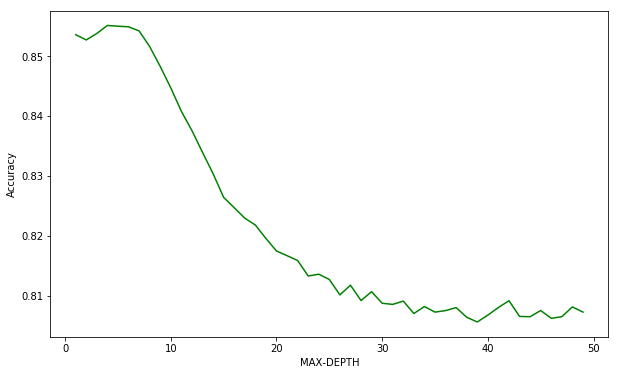

In [43]:
DT_best_params(tfidfw2v_train, y_train)

accuracy_score = 0.8551
precision_score = 0.8715676660128888
recall_score = 0.9734011343633875
F1_score = 0.919674039580908


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

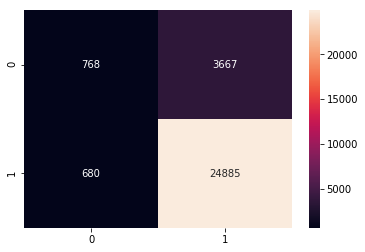

In [44]:
DT(4, tfidfw2v_train, y_train, tfidfw2v_test, y_test)

# BAG of WORDS

In [47]:
vect = CountVectorizer()

In [48]:
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [49]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [ ]:
joblib.dump(bow_X_train, 'bow_X_train.pkl') 
joblib.dump(bow_X_test, 'bow_X_test.pkl') 

In [ ]:
bow_X_train = joblib.load('bow_X_train.pkl') 
bow_X_test = joblib.load('bow_X_test.pkl') 

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 10.0min finished


best Accuracy: {'max_depth': 13}
best Score: 0.87004557598617


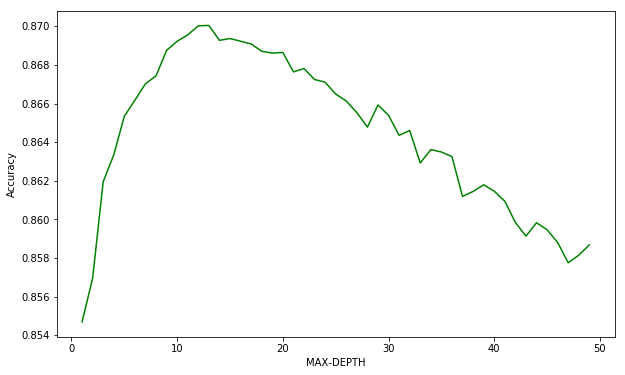

In [50]:
DT_best_params(bow_X_train, y_train)

accuracy_score = 0.8722
precision_score = 0.8813392763134805
recall_score = 0.9822804615685508
F1_score = 0.9290761774390469
Wall time: 6.55 s


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

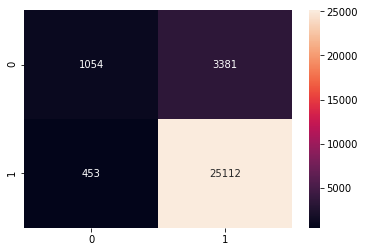

In [51]:
%time DT(13, bow_X_train, y_train, bow_X_test, y_test)

# TFIDF

In [20]:
vect = TfidfVectorizer()

In [21]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(tfidf_X_train)
tfidf_X_train

<70000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 2162199 stored elements in Compressed Sparse Row format>

In [22]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(tfidf_X_test)
tfidf_X_test

<30000x32149 sparse matrix of type '<class 'numpy.float64'>'
	with 880827 stored elements in Compressed Sparse Row format>

In [109]:
joblib.dump(tfidf_X_train, 'tfidf_X_train.pkl') 
joblib.dump(tfidf_X_test, 'tfidf_X_test.pkl') 

['tfidf_X_test.pkl']

In [111]:
tfidf_X_train = joblib.load('tfidf_X_train.pkl') 
tfidf_X_test = joblib.load('tfidf_X_test.pkl') 

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed:  7.9min finished


best Accuracy: {'max_depth': 13}
best Score: 0.8687254439729687


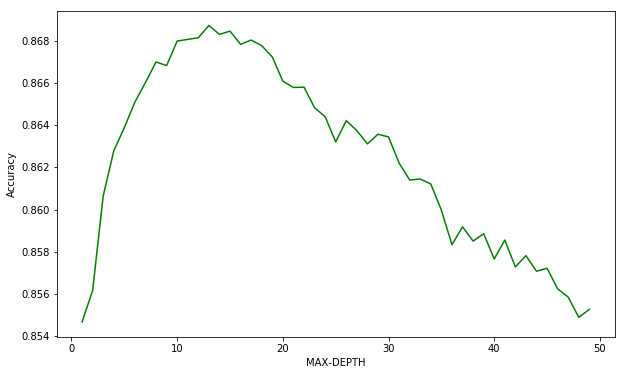

In [56]:
DT_best_params(tfidf_X_train, y_train)

accuracy_score = 0.8706666666666667
precision_score = 0.882141472526698
recall_score = 0.9790338353217289
F1_score = 0.928065556750343


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

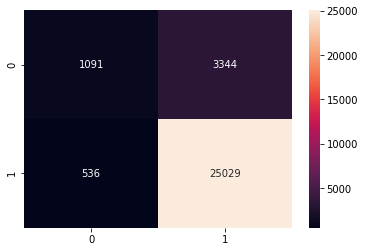

In [57]:
DT(13, tfidf_X_train, y_train, tfidf_X_test, y_test)

# Lets see the feature importance and decision tree on our best model TFIDF

In [18]:
def DT(max_depth, X_train, y_train, X_test, y_test) :
    clf = DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('accuracy_score =', accuracy_score(y_test, y_pred))
    print('precision_score =', precision_score(y_test, y_pred))
    print('recall_score =', recall_score(y_test, y_pred))
    print('F1_score =', f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    fi = clf.feature_importances_
    return y_pred, fi

accuracy_score = 0.8704666666666667
precision_score = 0.8821165438713998
recall_score = 0.9787991394484648
F1_score = 0.9279463027516132


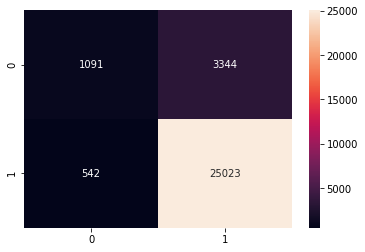

In [23]:
tfidf_fi = DT(13, tfidf_X_train, y_train, tfidf_X_test, y_test)

In [24]:
features = vect.get_feature_names()

In [29]:
tfidf_fi[1]

array([0., 0., 0., ..., 0., 0., 0.])

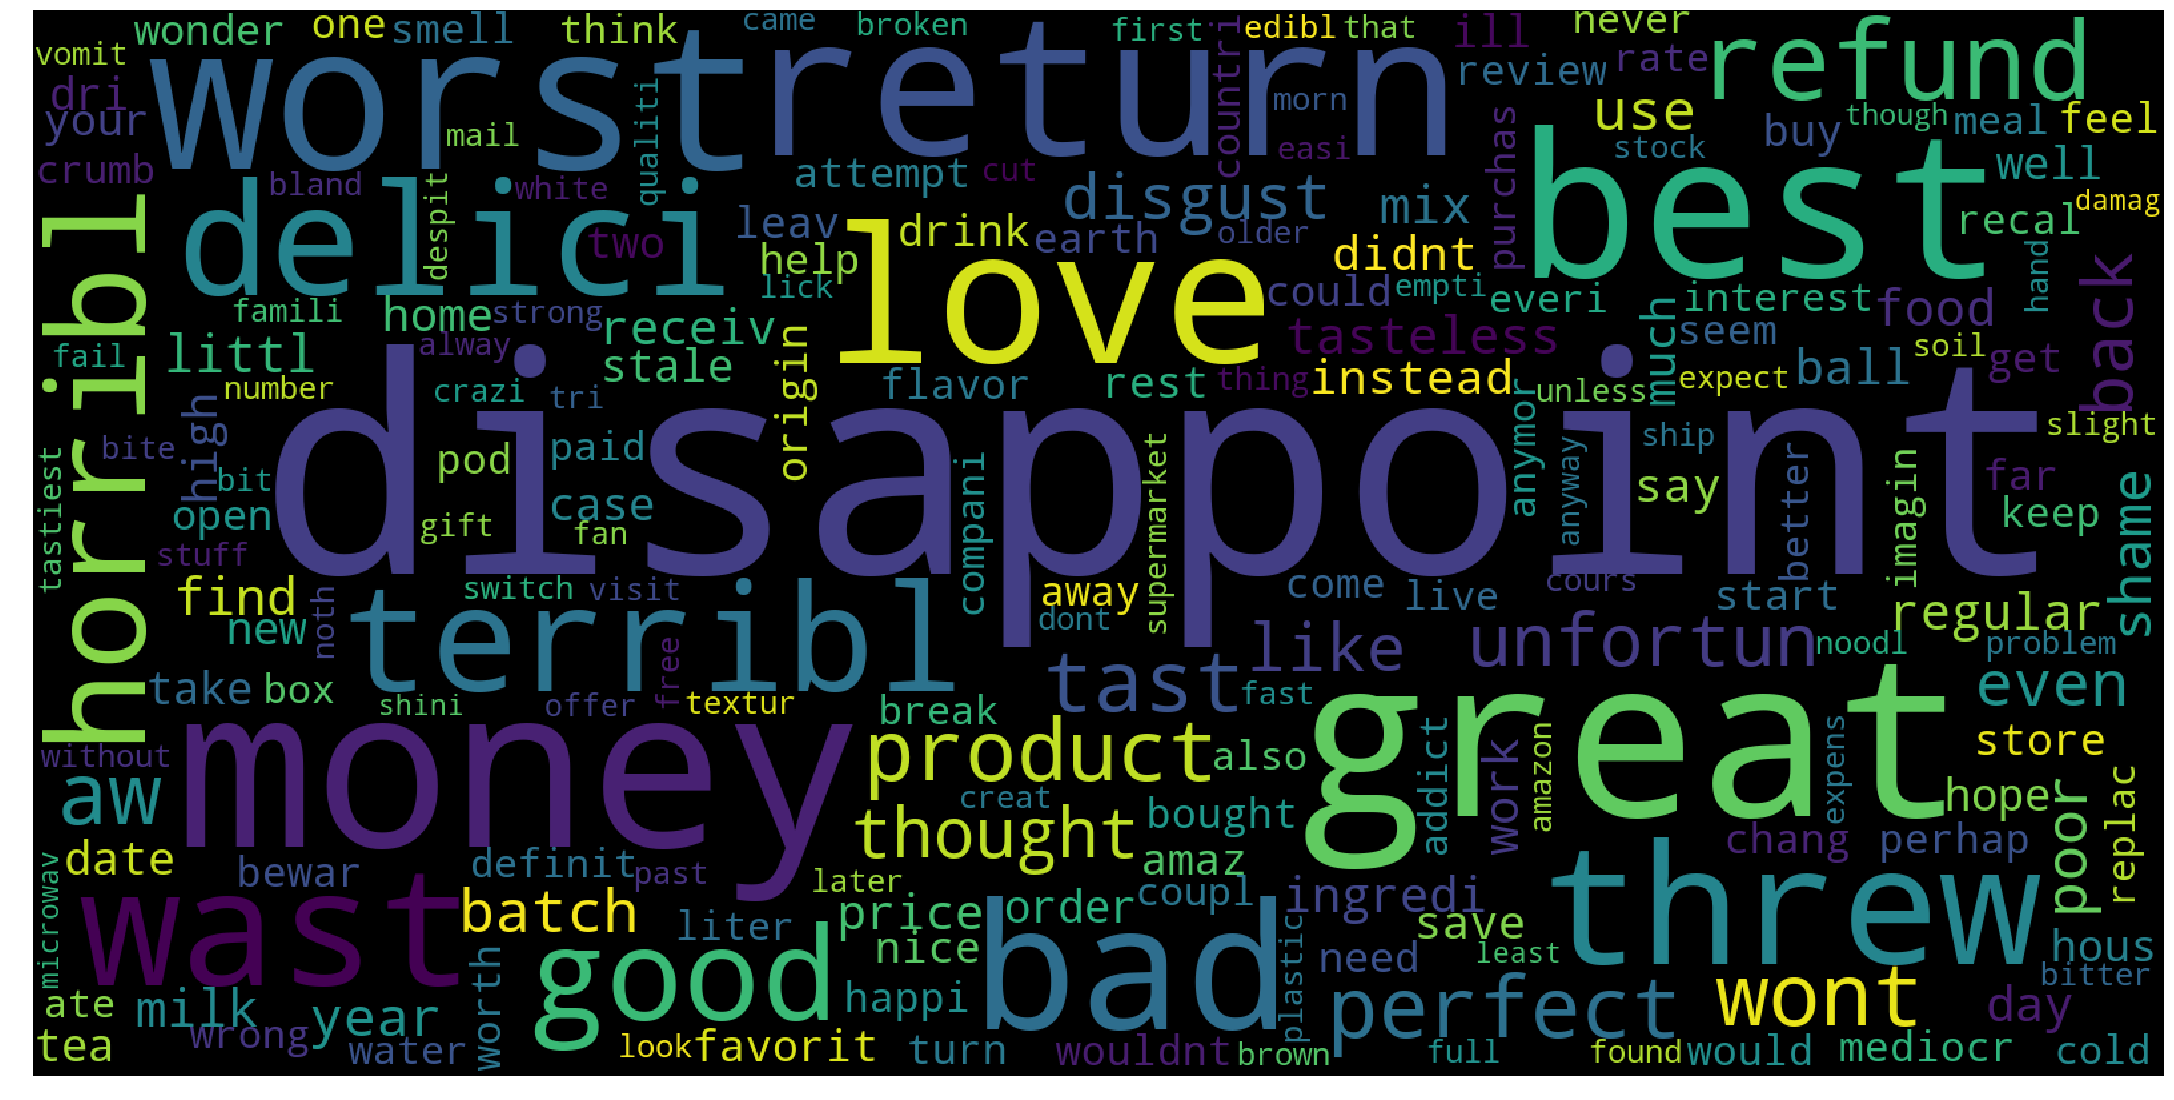

In [35]:
# Ploting word cloud
from wordcloud import WordCloud

freq = tfidf_fi[1]
words = vect.get_feature_names()
#freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(words, freq))

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()

In [88]:
clf = DecisionTreeClassifier(max_depth = 13)
clf.fit(tfidf_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [107]:
from sklearn import tree
tree = tree.export_graphviz(clf, out_file='TFIDF_D_tree.dot', max_depth=2, feature_names=vect.get_feature_names())

![alt text](DT.png "DT")

# RESULTS

In [58]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "Tree max-depth", "ACCURACY", "PRECISION", "RECALL", 'F1-SCORE' ]
#BOW
x.add_row(['BOW with DT GridSearch', '13', 0.87, 0.88, 0.98, 0.92])
x.add_row(['--'*5,'-'*5,'-'*8,'-'*5, '--'*5, '--'*5])
#TFIDF
x.add_row(['TFIDF with DT GridSearch', '13', 0.87, 0.88, 0.97, 0.92])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#AVGW2V
x.add_row(['AVGW2V with DT GridSearch', '6', 0.86, 0.88, 0.97, 0.92])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*5, '--'*5])
#TFIDFW2V
x.add_row(['TFIDFW2V with DT GridSearch', '4', 0.85, 0.87, 0.97, 0.91])
print(x)

+-----------------------------+----------------+----------+-----------+------------+------------+
|            MODEL            | Tree max-depth | ACCURACY | PRECISION |   RECALL   |  F1-SCORE  |
+-----------------------------+----------------+----------+-----------+------------+------------+
|    BOW with DT GridSearch   |       13       |   0.87   |    0.88   |    0.98    |    0.92    |
|          ----------         |     -----      | -------- |   -----   | ---------- | ---------- |
|   TFIDF with DT GridSearch  |       13       |   0.87   |    0.88   |    0.97    |    0.92    |
|          ----------         |    --------    | -------- |   -----   | ---------- | ---------- |
|  AVGW2V with DT GridSearch  |       6        |   0.86   |    0.88   |    0.97    |    0.92    |
|          ----------         |    --------    | -------- |   -----   | ---------- | ---------- |
| TFIDFW2V with DT GridSearch |       4        |   0.85   |    0.87   |    0.97    |    0.91    |
+-------------------

In [108]:
#number of positive and negative values in test data
y_test.value_counts()

1    25565
0     4435
Name: Score, dtype: int64

**OBSERVATIONS**

since AVGW2v and TFIDFW2V took too much time for converting to a vector. the total number of datapoints used are limited to 100K. also, the BOW & TFIDF were trained on all data and the confusion matrix and accuracy score were same in percentages.


1. The best results were obtained from TFIDF with closely 3.8k mis-classifications out of 30k datapoints.

2. DT still lags behind Logistic Regression Model. the maximum misclassification in logistic regression was 2.5k. but this exceeds to atleast 4k misclassification in all models. 

3. almost all the model till now has tough in predicting negative reviews.

4. since this data is imbalanced, there are large amount of data for positive reviews. so, the False positive rate is very high on almost all the vectorizers. W2V perfom very bad on this.

5. using SKlearn DT .dot file is generated and sample DT is visualised online graphviz and as we can see in DT. Disappoint is the main word with highest gini impurity